In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

### 1. Dataset Definition ---------------------------------------------

In [47]:
# --- 1. Dataset Definition ---------------------------------------------
class PatchDataset(Dataset):
    def __init__(self, imgs, labels):
        """
        imgs: numpy array shape (N, H, W)
        labels: numpy array shape (N,)
        """
        self.x = torch.from_numpy(imgs).float()
        if self.x.ndim == 3:
            self.x = self.x.unsqueeze(1) # add channel dimension
        self.y = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


### 2. Load data -------------------------------------------------------

In [138]:


# --- 2. Load data -------------------------------------------------------
# Replace these paths with your actual .npy files
A = np.load("data/augmented_images_algoA.npy")  # shape (N_A,50,50)
B = np.load("data/augmented_images_algoB.npy")  # shape (N_B,50,50)

# concatenate and create labels
imgs = np.concatenate([A, B], axis=0)
labels = np.concatenate([np.zeros(len(A), dtype=int),
                         np.ones(len(B), dtype=int)], axis=0)

# create dataset and split
dataset = PatchDataset(imgs, labels)
n_train = int(0.8 * len(dataset))
n_val = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on {n_train} samples, validating on {len(dataset) - n_train} samples")


Training on 1600 samples, validating on 400 samples


### 3. Model Definition -----------------------------------------------

In [165]:

# --- 3. Model Definition -----------------------------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, n_classes=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 25×25
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 12×12
        )
        self.fc = nn.Linear(32 * 12 * 12, n_classes)
        # self.fc2 = nn.Linear(5, n_classes)
        self.final = nn.Softmax(dim=1)
        

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.final((self.fc(x)))

    def sublayer(self,x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return x

model = SmallCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

### 4. Training Loop --------------------------------------------------

In [166]:
# --- 4. Training Loop --------------------------------------------------
n_epochs = 20
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_dl.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
    val_loss = running_loss / len(val_dl.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")





Epoch 1/20 — Train Loss: 0.6542, Val Loss: 0.5806
Epoch 2/20 — Train Loss: 0.4817, Val Loss: 0.4027
Epoch 3/20 — Train Loss: 0.3577, Val Loss: 0.3359
Epoch 4/20 — Train Loss: 0.3237, Val Loss: 0.3189
Epoch 5/20 — Train Loss: 0.3170, Val Loss: 0.3166
Epoch 6/20 — Train Loss: 0.3155, Val Loss: 0.3155
Epoch 7/20 — Train Loss: 0.3148, Val Loss: 0.3148
Epoch 8/20 — Train Loss: 0.3143, Val Loss: 0.3145
Epoch 9/20 — Train Loss: 0.3141, Val Loss: 0.3142
Epoch 10/20 — Train Loss: 0.3139, Val Loss: 0.3140
Epoch 11/20 — Train Loss: 0.3137, Val Loss: 0.3138
Epoch 12/20 — Train Loss: 0.3136, Val Loss: 0.3137
Epoch 13/20 — Train Loss: 0.3136, Val Loss: 0.3137
Epoch 14/20 — Train Loss: 0.3135, Val Loss: 0.3136
Epoch 15/20 — Train Loss: 0.3135, Val Loss: 0.3136
Epoch 16/20 — Train Loss: 0.3134, Val Loss: 0.3135
Epoch 17/20 — Train Loss: 0.3134, Val Loss: 0.3135
Epoch 18/20 — Train Loss: 0.3134, Val Loss: 0.3135
Epoch 19/20 — Train Loss: 0.3134, Val Loss: 0.3134
Epoch 20/20 — Train Loss: 0.3134, Val Lo

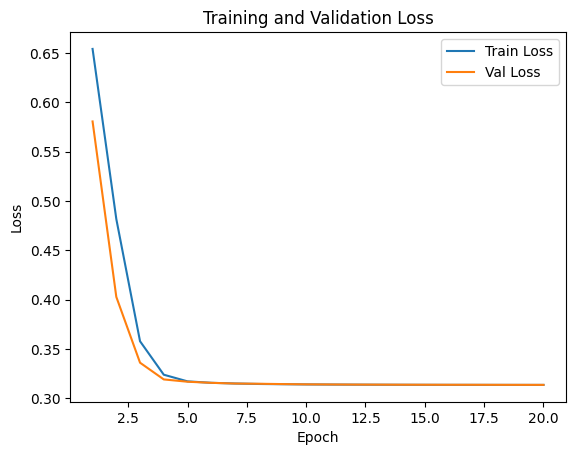

In [ ]:
# --- 5. Save Model -----------------------------------------------------
torch.save(model.state_dict(), "models/small_cnn.pth")

# --- 6. Plot Loss Curves ------------------------------------------------
plt.figure()
plt.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Test on some cases

torch.Size([1, 50, 50]) tensor(1)
tensor(0.7063)
tensor([[1.0475e-05, 9.9999e-01]], device='cuda:0')
Predicted class: 1, Actual class: 1


(-0.5, 49.5, 49.5, -0.5)

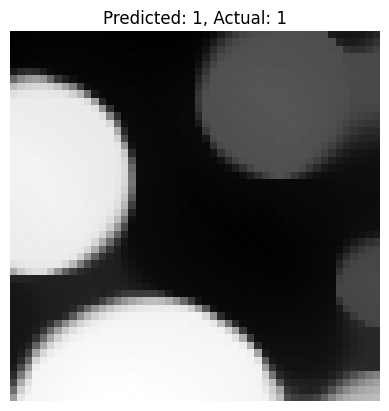

In [144]:
index = np.random.randint(0, len(val_ds))
x, y = val_ds.__getitem__(index)
print(x.shape, y)  # Check the shape of the first image and its label
print(torch.max(x))
model.eval()
with torch.no_grad():
    x = x.unsqueeze(0).to(device)  # Add batch dimension
    out = model(x)
    print(out)
    pred = torch.argmax(out, dim=1).item()
    print(f"Predicted class: {pred}, Actual class: {y.item()}")

# plot the image
plt.imshow(x.squeeze().cpu(), cmap='gray')
plt.title(f"Predicted: {pred}, Actual: {y.item()}")
plt.axis('off')

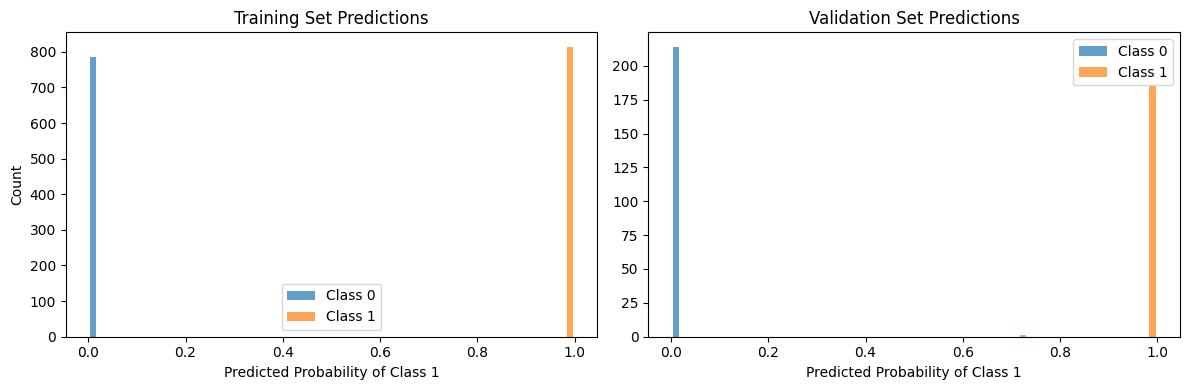

In [158]:
# Get predictions for validation set
val_preds_probs = []
val_true_labels = []
model.eval()
with torch.no_grad():
    for x, y in val_dl:
        x = x.to(device)
        out = model(x)
        probs = out[:, 1]  # probability of class 1
        val_preds_probs.extend(probs.cpu().numpy())
        val_true_labels.extend(y.numpy())

# Get predictions for training set        
train_preds_probs = []
train_true_labels = []
with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        out = model(x)
        probs = out[:, 1]
        train_preds_probs.extend(probs.cpu().numpy())
        train_true_labels.extend(y.numpy())

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Training set
ax1.hist([np.array(train_preds_probs)[np.array(train_true_labels)==0], 
          np.array(train_preds_probs)[np.array(train_true_labels)==1]], 
         label=['Class 0', 'Class 1'], bins=30, alpha=0.7)
ax1.set_title('Training Set Predictions')
ax1.set_xlabel('Predicted Probability of Class 1')
ax1.set_ylabel('Count')
ax1.legend()

# Validation set
ax2.hist([np.array(val_preds_probs)[np.array(val_true_labels)==0],
          np.array(val_preds_probs)[np.array(val_true_labels)==1]], 
         label=['Class 0', 'Class 1'], bins=30, alpha=0.7)
ax2.set_title('Validation Set Predictions')
ax2.set_xlabel('Predicted Probability of Class 1')
ax2.legend()

plt.tight_layout()
plt.show()

In [163]:
def get_features(model, dataloader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            feat = model.sublayer(x)
            feat = feat.view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.extend(y.numpy())
            
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

# Get features for both training and validation sets
train_features, train_labels = get_features(model, train_dl, device)

print("Train features shape:", train_features.shape)

Train features shape: (1600, 5)


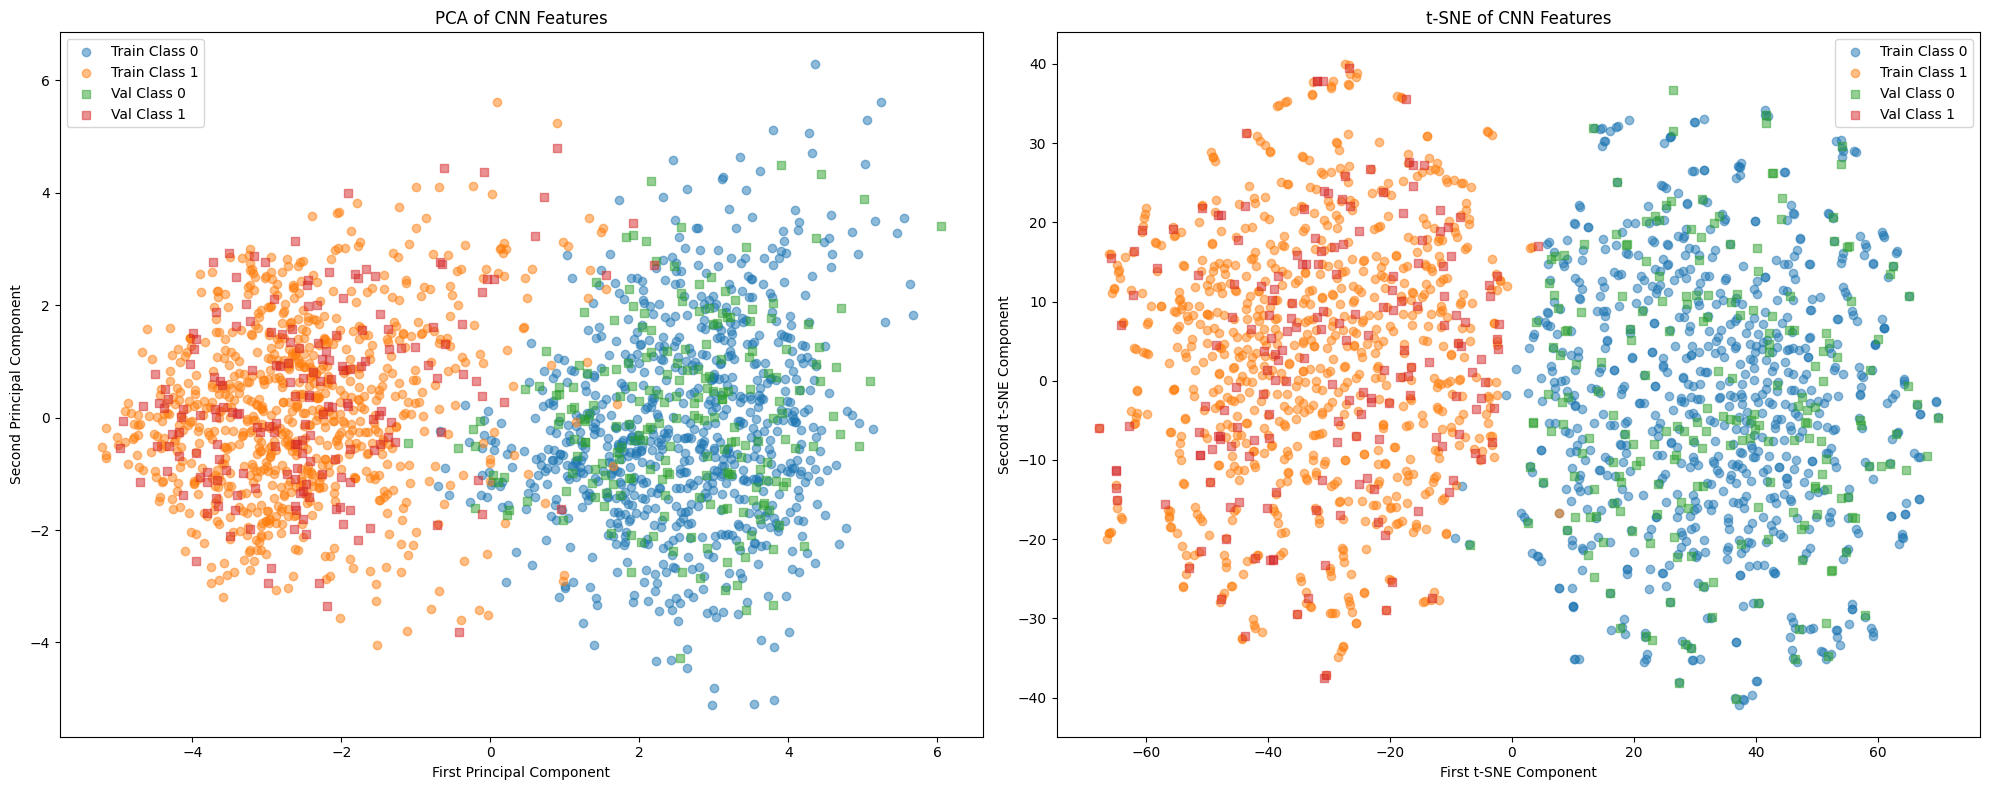

PCA explained variance ratio: [0.1745194  0.06213227]


In [164]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get features from the last layer before classification
def get_features(model, dataloader, device):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            feat = model.conv(x)
            feat = feat.view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.extend(y.numpy())
            
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

# Get features for both training and validation sets
train_features, train_labels = get_features(model, train_dl, device)
val_features, val_labels = get_features(model, val_dl, device)

# Combine train and val features
all_features = np.concatenate([train_features, val_features])

# Apply PCA and t-SNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42)

# Transform features
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)
all_features_tsne = tsne.fit_transform(all_features)

# Split t-SNE results back into train and val
train_features_tsne = all_features_tsne[:len(train_features)]
val_features_tsne = all_features_tsne[len(train_features):]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot PCA
ax1.scatter(train_features_pca[train_labels==0,0], train_features_pca[train_labels==0,1], 
           alpha=0.5, label='Train Class 0')
ax1.scatter(train_features_pca[train_labels==1,0], train_features_pca[train_labels==1,1], 
           alpha=0.5, label='Train Class 1')
ax1.scatter(val_features_pca[val_labels==0,0], val_features_pca[val_labels==0,1], 
           alpha=0.5, marker='s', label='Val Class 0')
ax1.scatter(val_features_pca[val_labels==1,0], val_features_pca[val_labels==1,1], 
           alpha=0.5, marker='s', label='Val Class 1')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title('PCA of CNN Features')
ax1.legend()

# Plot t-SNE
ax2.scatter(train_features_tsne[train_labels==0,0], train_features_tsne[train_labels==0,1], 
           alpha=0.5, label='Train Class 0')
ax2.scatter(train_features_tsne[train_labels==1,0], train_features_tsne[train_labels==1,1], 
           alpha=0.5, label='Train Class 1')
ax2.scatter(val_features_tsne[val_labels==0,0], val_features_tsne[val_labels==0,1], 
           alpha=0.5, marker='s', label='Val Class 0')
ax2.scatter(val_features_tsne[val_labels==1,0], val_features_tsne[val_labels==1,1], 
           alpha=0.5, marker='s', label='Val Class 1')
ax2.set_xlabel('First t-SNE Component')
ax2.set_ylabel('Second t-SNE Component')
ax2.set_title('t-SNE of CNN Features')
ax2.legend()

plt.tight_layout()
plt.show()

# Print explained variance ratio for PCA
print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# Harmonisation